In [1]:
using Distributions, QuadGK, Statistics, LinearAlgebra, Optim, Interpolations, Plots, Printf, ForwardDiff, PrettyTables, Distributed, Base.Threads, ImageFiltering
using StatsBase: mad

In [3]:
# Model parameter struct
Base.@kwdef mutable struct ModelParams
    r::Float64          # Discount rate
    δ::Float64          # Productivity shock rate
    ξ::Float64          # Exogenous destruction rate
    β::Float64          # Bargaining power of workers
    c::Float64          # Vacancy cost
    A::Float64          # Matching function scale
    η::Float64          # Matching efficiency
    s::Float64          # Search intensity (employed)
    α::Float64          # CES production function weight
    ρ::Float64          # CES production function parameter
    b::Float64          # Home production parameter
    ax::Float64         # Worker Beta dist. shape1
    bx::Float64         # Worker Beta dist. shape2
    ay::Float64         # Firm Beta dist. shape1
    by::Float64         # Firm Beta dist. shape2
    σ²::Float64=0.0     # Measurement error (optional)
end

# Grid parameter struct
mutable struct GridParams
    nx::Int
    ny::Int
    x_grid::Vector{Float64}
    y_grid::Vector{Float64}
end

mutable struct State
    h::Array{Float64,2}   # Joint match distribution (nx × ny)
    S::Array{Float64,2}   # Surplus function (nx × ny)
    u::Vector{Float64}    # Unemployment by type (nx)
    v::Vector{Float64}    # Vacancy by type (ny)
    κ::Float64            # Market tightness
    V::Float64            # Number of vacancies
    N::Float64            # Number of jobs
    Pi0::Vector{Float64}  # Value function for vacancies (ny)
end

In [4]:
function trapz(x, y)
    n = length(x)
    dx = x[2] - x[1]
    return dx * (sum(y) - 0.5 * (y[1] + y[end]))
end

trapz (generic function with 1 method)

In [5]:
const MAD_NORM = 1.482602218505602

# robust scale of a matrix/vector (MAD)
robust_scale(x) = begin
    xv = vec(x)
    m  = median(xv)
    s  = MAD_NORM * median(abs.(xv .- m))
    s > 0 ? s : eps(eltype(x))
end

robust_scale (generic function with 1 method)

In [6]:
# local, parameter-free kink detector (relative jump vs. neighbors)
function kink_intervals_1d(y::AbstractVector)
    n = length(y)
    ks = BitVector(false for _ in 1:(n-1))
    for i in 2:(n-2)
        d0 = abs(y[i]   - y[i-1]) + 1e-15
        d1 = abs(y[i+1] - y[i])
        d2 = abs(y[i+2] - y[i+1]) + 1e-15
        # order-of-magnitude jump relative to both sides
        if d1 > 10 * max(d0, d2)
            ks[i] = true  # interval [i, i+1] is a kink
        end
    end
    return ks
end

function trapz_skip_kinks(x::AbstractVector, y::AbstractVector)
    @assert length(x) == length(y)
    dx = x[2] - x[1]  # uniform grid assumed
    ks = kink_intervals_1d(y)
    area = 0.0
    for i in 1:(length(y)-1)
        if !ks[i]
            area += 0.5 * dx * (y[i] + y[i+1])
        end
    end
    return area
end


trapz_skip_kinks (generic function with 1 method)

In [7]:
function make_grids(nx::Int, ny::Int)
    x_grid = collect(range(0.0, stop=1.0, length=nx+2))[2:end-1]
    y_grid = collect(range(0.0, stop=1.0, length=ny+2))[2:end-1]
    return GridParams(nx, ny, x_grid, y_grid)
end

make_grids (generic function with 1 method)

In [8]:
function find_best_epsilon(α, β, grid; tol=1e-5)
    beta_dist = Beta(α, β)
    dx_min = minimum(diff(sort(grid)))             # smallest grid spacing
    ϵ_low, ϵ_high = 1e-12, min(0.05, dx_min / 2)    # cap epsilon

    best_ϵ = ϵ_low
    best_integral = 0.0

    # Binary search for the largest integral < 1
    for _ in 1:50
        ϵ = (ϵ_low + ϵ_high) / 2
        ℓ = x -> (x < 0 || x > 1) ? 0.0 : pdf(beta_dist, clamp(x, ϵ, 1 - ϵ))
        ℓ_vec = [ℓ(x) for x in grid]
        integral = trapz(grid, ℓ_vec)

        if integral < 1.0
            if integral > best_integral
                best_integral = integral
                best_ϵ = ϵ
            end
            ϵ_low = ϵ
        else
            ϵ_high = ϵ
        end

        if abs(1.0 - integral) < tol && integral < 1.0
            break
        end
    end
    return best_ϵ, best_integral
end

find_best_epsilon (generic function with 1 method)

In [9]:
function beta_dist(α, β; grid=nothing, tol=1e-10)
    d = Beta(α, β)
    ϵ = if grid !== nothing
        ϵ, _ = find_best_epsilon(α, β, grid; tol=tol)
        ϵ
    else
        (α < 1 || β < 1) ? sqrt(eps(Float64)) : 0.0
    end
    ℓ = x -> (x <= 0 || x >= 1) ? pdf(d, ϵ) : pdf(d, clamp(x, ϵ, 1-ϵ))
    L = x -> x <= 0 ? 0.0 : (x >= 1 ? 1.0 : cdf(d, x))
    return ℓ, L
end

beta_dist (generic function with 1 method)

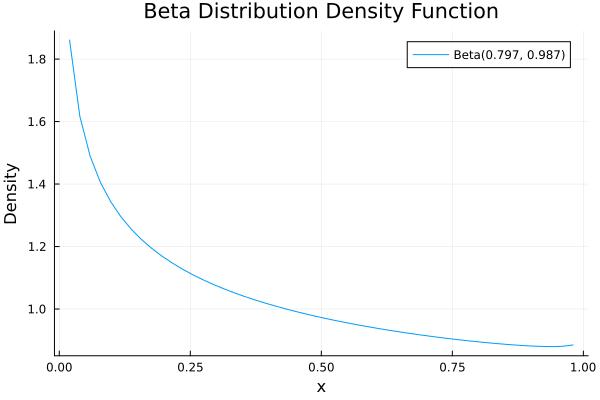

In [10]:
x_grid = collect(range(0.0, stop=1.0, length=52))[2:end-1]
test_dist = beta_dist(0.797, 0.987, grid = x_grid)
test_dist_vec = [test_dist[1](x) for x in x_grid]
test_dist_vec ./= trapz(x_grid, test_dist_vec)
plot(x_grid, test_dist_vec, label="Beta(0.797, 0.987)", xlabel="x", ylabel="Density", title="Beta Distribution Density Function")

In [11]:
int_test = trapz(x_grid, test_dist_vec)
println("Integral of test distribution: ", int_test)

Integral of test distribution: 1.0000000000000002


In [12]:
# Example parameter values (adapt as needed)
params = ModelParams(
    r = 0.05,
    δ = 0.017,
    ξ = 0.011,
    β = 0.188,
    c = 2.344,
    A = 6.96,
    η = 0.65,
    s = 0.332,
    α = 0.607,
    ρ = 0.938,
    b = 0.122,
    ax = 0.797,
    bx = 0.987,
    ay = 1.988,
    by = 0.967,
    σ² = 0.006
)

# Make grids
grid = make_grids(100, 100)

# Example: worker beta density and CDF on grid
ℓx, Lx = beta_dist(params.ax, params.bx, grid = grid.x_grid)
ℓy, Ly = beta_dist(params.ay, params.by, grid = grid.y_grid)

# Evaluate densities on the grids (as vectors)
ℓx_vec = [ℓx(x) for x in grid.x_grid]
ℓx_vec ./= trapz(grid.x_grid, ℓx_vec)

ℓy_vec = [ℓy(y) for y in grid.y_grid]
ℓy_vec ./= trapz(grid.y_grid, ℓy_vec)

100-element Vector{Float64}:
 0.020250326786411
 0.04017849918900962
 0.0599953201432994
 0.07974506936873928
 0.099448777670243
 0.1191188775326727
 0.13876363896081667
 0.15838899596767034
 0.17799944041052626
 0.19759851207953505
 0.21718909021040336
 0.23677357789519382
 0.25635402452791894
 ⋮
 1.8315398882955138
 1.8571957308568114
 1.883496994686478
 1.9105763897094723
 1.93861344125596
 1.9678596462851734
 1.9986832217370365
 2.031655199917755
 2.067733336964934
 2.1087174763685987
 2.158666830737362
 2.2306530986291198

In [13]:
function initialise_model(params::ModelParams, nx::Int, ny::Int)
    # Grids
    x_grid = collect(range(0.0, stop=1.0, length=nx+2))[2:end-1]
    y_grid = collect(range(0.0, stop=1.0, length=ny+2))[2:end-1]
    grid = GridParams(nx, ny, x_grid, y_grid)

    # Beta densities
    ℓx, _ = beta_dist(params.ax, params.bx, grid=grid.x_grid)
    ℓy, _ = beta_dist(params.ay, params.by, grid=grid.y_grid)
    ℓx_vec = [ℓx(x) for x in x_grid]
    ℓx_vec ./= (trapz(x_grid, ℓx_vec))  # Normalize to minimize numerical inaccuracies when integrating
    ℓy_vec = [ℓy(y) for y in y_grid]
    ℓy_vec ./= (trapz(y_grid, ℓy_vec)) 

    # Production matrix and b(x)
    fmat = [f_xy(x, y, params) for x in x_grid, y in y_grid]
    b_vec = params.b .* ℓx_vec  # Home production for workers

    # Joint match distribution (h) initialization
    # h is initialized as a matrix of products of densities
    h = [ℓx_vec[i] * ℓy_vec[j] for i in 1:nx, j in 1:ny]
    h ./= sum(h)  # Normalize to sum to 1
    h .*= 0.1     # Scale so that matches are a small fraction of mass

    # Initial endogenous variables (small values for h/S to avoid zeros)
    #h = fill(1e-8, nx, ny)
    S = fill(1e-8, nx, ny)
    u = fill(1e-8, nx)
    v = fill(1e-8, ny)
    κ = 0.1
    V = 1.0
    N = 1.0
    Pi0 = zeros(ny)

    # Bundle state
    state = State(h, S, u, v, κ, V, N, Pi0)

    # Return everything you might need for the solver
    return state, grid, ℓx_vec, ℓy_vec, fmat, b_vec
end


initialise_model (generic function with 1 method)

In [14]:
function f_xy(x, y, params::ModelParams)
    α, ρ, A = params.α, params.ρ, params.A
    return A * (α * x^ρ + (1 - α) * y^ρ)^(1/ρ)
end

function f_xy_grid(x_grid, y_grid, params::ModelParams)
    nx, ny = length(x_grid), length(y_grid)
    fmat = Array{Float64}(undef, nx, ny)
    for i in 1:nx
        for j in 1:ny
            fmat[i, j] = f_xy(x_grid[i], y_grid[j], params)
        end
    end
    return fmat
end

f_xy_grid (generic function with 1 method)

In [15]:
# Matching function (scalar)
function matching(U, V, params::ModelParams)
    η, s = params.η, params.s
    eff_job_seekers = U + s*(1 - U)
    return η * sqrt(eff_job_seekers * V)
end

# Market tightness: kappa = M(...) / ([U + s(1-U)] * V)
function compute_kappa(U, V, params::ModelParams)
    Mval = matching(U, V, params)
    eff_job_seekers = U + params.s*(1 - U)
    return Mval / (eff_job_seekers * V)
end

# Invert the matching function to get V for given kappa and U
function solve_V_from_kappa(kappa, U, params::ModelParams)
    η, s = params.η, params.s
    eff_job_seekers = U + s*(1 - U)
    # From: kappa = η * sqrt(eff_job_seekers * V) / (eff_job_seekers * V)
    #       = η / sqrt(eff_job_seekers * V)
    #   => sqrt(eff_job_seekers * V) = η / kappa
    #   => eff_job_seekers * V = (η / kappa)^2
    #   => V = (η / kappa)^2 / eff_job_seekers
    return (η / kappa)^2 / eff_job_seekers
end

solve_V_from_kappa (generic function with 1 method)

In [16]:
function init_endogenous_arrays(grid::GridParams)
    nx, ny = grid.nx, grid.ny
    h = zeros(nx, ny)        # Match distribution
    S = zeros(nx, ny)        # Surplus function
    u = zeros(nx)            # Unemployment distribution
    v = zeros(ny)            # Vacancy distribution
    return h, S, u, v
end

init_endogenous_arrays (generic function with 1 method)

In [17]:
fmat = f_xy_grid(grid.x_grid, grid.y_grid, params)
h, S, u, v = init_endogenous_arrays(grid)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [18]:
function update_ux(h, ℓx_vec, y_grid)
    nx, ny = size(h)
    u = zeros(nx)
    @threads for i in 1:nx
        u[i] = ℓx_vec[i] - trapz(y_grid, h[i, :])
    end
    u .= max.(u, 0.0)
    return u
end

function compute_U(u, x_grid)
    return trapz(x_grid, u)
end

function update_vy(h, N, ℓy_vec, x_grid)
    nx, ny = size(h)
    v = zeros(ny)
    @threads for j in 1:ny
        v[j] = N * ℓy_vec[j] - trapz(x_grid, h[:, j])
    end
    return v
end

function solve_V_from_kappa(kappa, U, params::ModelParams)
    η, s = params.η, params.s
    eff_job_seekers = U + s * (1 - U)
    return (η^2) / (kappa^2 * eff_job_seekers)
end

function update_vy(h, N, ℓy_vec, x_grid)
    # v(y) = N * ℓ(y) - ∫ h(x, y) dx
    nx, ny = size(h)
    v = zeros(ny)
    @threads for j in 1:ny
        v[j] = N * ℓy_vec[j] - trapz(x_grid, h[:, j])
    end
    return v
end

update_vy (generic function with 1 method)

In [19]:
#integrate h(x,y) twice
function integrate_hxy(h, x_grid, y_grid)
    # Integrate h over x and y
    integral_x = [trapz(y_grid, h[i, :]) for i in 1:size(h, 1)]
    integral_xy = trapz(x_grid, integral_x)
    return integral_xy
end

integrate_hxy (generic function with 1 method)

In [20]:
function remove_spikes!(A; thresh=5.0)
    n1, n2 = size(A)
    for i in 2:(n1-1), j in 2:(n2-1)
        neighbors = [A[i-1,j], A[i+1,j], A[i,j-1], A[i,j+1]]
        neighbor_mean = mean(neighbors)
        neighbor_std = std(neighbors)
        # Detect spike: value much larger than neighbors AND neighbors are similar
        if (abs(A[i,j] - neighbor_mean) > thresh * (neighbor_std + 1e-12)) &&
           (neighbor_std < 1e-3 * abs(neighbor_mean) + 1e-10)
            A[i,j] = neighbor_mean
        end
    end
    return nothing
end

remove_spikes! (generic function with 1 method)

In [21]:
function update_hxy(h, u, v, S, κ, V_total, params, grid)
    # h(x,y) update using steady-state flow equation
    nx, ny = size(h)
    δ, ξ, s = params.δ, params.ξ, params.s
    x_grid, y_grid = grid.x_grid, grid.y_grid

    h_new = zeros(nx, ny)

    @threads for i in 1:nx
        # Precompute h(x, y') and v(y') over y'
        h_row = h[i, :]
        S_row = S[i, :]

        @threads for j in 1:ny
            S_xy = S[i, j]

            # Find indices where S(x, y') ≥ S(x, y)
            B_mask = S_row .>= S_xy

            # Compute integrals by summing over those y' where S(x, y') ≥ S(x, y)
            h_B = trapz(y_grid, h_row .* B_mask)
            V_B = trapz(y_grid, v .* B_mask)

            numerator = δ * trapz(y_grid, h_row) + (u[i] + s * h_B) * κ * v[j]
            denominator = δ + ξ + s * κ * V_B

            # Regularization to prevent dividing by zero
            epsilon = 1e-8
            denominator = max(denominator, epsilon)
            h_new[i, j] = numerator / denominator 
            # Ensure non-negative matches
            h_new[i, j] = max(h_new[i, j], 0.0)
        end
    end

    # --- Normalization step ---
    total_h_mass = integrate_hxy(h_new, x_grid, y_grid)
    if total_h_mass > 1.0
        h_new .*= (1.0 / total_h_mass)
    end
    
    
    return h_new
end


update_hxy (generic function with 1 method)

In [22]:
function update_Sxy(S, h, u, v, κ, params, grid, ℓy_vec, fmat, b_vec)
    nx, ny = size(S)
    r, δ, ξ, β, s, c = params.r, params.δ, params.ξ, params.β, params.s, params.c
    x_grid, y_grid = grid.x_grid, grid.y_grid

    S_new = zeros(nx, ny)

    for i in 1:nx
        for j in 1:ny
            # Precompute values for this (x, y)
            S_xy = S[i, j]
            fxy = fmat[i, j]
            bx = b_vec[i]

            # --- Integrals over y' (at fixed x) ---
            # 1. ∫ S(x, y')^+ v(y') dy'
            S_x_row = S[i, :]
            int1 = trapz(y_grid, max.(S_x_row, 0.0) .* v)

            # 2. ∫ [S(x, y') - S(x, y)]^+ v(y') dy'
            diff_S_y = max.(S_x_row .- S_xy, 0.0)
            int2 = trapz(y_grid, diff_S_y .* v)

            # 3. ∫ S(x, y')^+ γ(y') dy'
            int3 = trapz(y_grid, max.(S_x_row, 0.0) .* ℓy_vec)

            # --- Integrals over x' (at fixed y) ---
            # 4. ∫ S(x, y)^+ u(x) dx
            S_y_col = S[:, j]
            int4 = trapz(x_grid, max.(S_y_col, 0.0) .* u)

            # --- Double integral over x', y' ---
            # 5. ∬ [S(x, y) - S(x, y')]^+ h(x, y') dx dy'
            # For each y', form max(S_xy - S[i, y'], 0.0), multiply by h[i, y'], then integrate over y'
            integrand = max.(S_xy .- S_x_row, 0.0) .* h[i, :]
            int5 = trapz(y_grid, integrand)  # dx comes outside: we integrate in y' at fixed x

            # Double integral over x for all i: int5 = trapz(x_grid, ...) but here just at i

            # --- Build the surplus update ---
            numer = fxy - bx + c
            numer -= κ * β * int1
            numer -= κ * (1 - β) * int4
            numer -= s * κ * (1 - β) * int5
            numer += β * s * κ * int2
            numer += δ * int3

            denom = r + δ + ξ

            S_new[i, j] = numer / denom
            S_new[i, j] = max(S_new[i, j], 0.0)  # Ensure non-negative surplus
        end
    end
    return S_new
end


update_Sxy (generic function with 1 method)

In [23]:
function update_Pi0!(Pi0, S, h, u, κ, params, grid, ℓx_vec, ℓy_vec)
    nx, ny = size(S)
    r, δ, β, c, s = params.r, params.δ, params.β, params.c, params.s
    x_grid, y_grid = grid.x_grid, grid.y_grid

    Pi0_new = zeros(ny)
    @threads for j in 1:ny
        # 1. ∫ S(x, y)^+ u(x) dx
        S_y_col = S[:, j]
        int1 = trapz(x_grid, max.(S_y_col, 0.0) .* u)

        # 2. ∬ [S(x, y) - S(x, y')]^+ h(x, y') dx dy'
        int2 = 0.0
        for i in 1:nx
            S_xy = S[i, j]
            # Over y' for this x
            diff = max.(S_xy .- S[i, :], 0.0) .* h[i, :]
            int2 += trapz(y_grid, diff)
        end
        int2 = int2 / nx  # (divide by nx for averaging, as needed)

        # 3. δ ∫ [Pi0(y') - Pi0(y)] γ(y') dy'
        int3 = trapz(y_grid, (Pi0 .- Pi0[j]) .* ℓy_vec)

        numer = -c + (1 - β) * κ * int1 + (1 - β) * κ * s * int2 + δ * int3
        denom = r + δ

        Pi0_new[j] = numer / denom
    end
    Pi0 .= Pi0_new  # In-place update
end

update_Pi0! (generic function with 1 method)

In [24]:
function update_kappa(S, u, h, Pi0, params, grid, ℓy_vec, y_grid, x_grid)
    β, c, δ, s = params.β, params.c, params.δ, params.s

    # Numerator
    int_Pi0 = trapz(y_grid, Pi0 .* ℓy_vec)
    numerator = c - δ * int_Pi0

    # Denominator: first y value = index 1
    S_x0 = S[:, 1]
    term1 = trapz(x_grid, max.(S_x0, 0.0) .* u)

    # Double integral: for each x, integrate over y'
    term2 = 0.0
    @threads for i in 1:length(x_grid)
        diffs = max.(S_x0[i] .- S[i, :], 0.0) .* h[i, :]
        term2 += trapz(y_grid, diffs)
    end
    term2 *= (x_grid[2] - x_grid[1])  # dx

    denominator = term1 + s * term2

    κ_new = denominator == 0 ? 1.0 : (numerator / denominator) / (1 - β)
    #println("kappa numerator: ", numerator, ", denominator: ", denominator)
    κ_new = clamp(κ_new, 1e-8, 100.0)
    return κ_new
end

update_kappa (generic function with 1 method)

In [25]:
# robust z-scores (MAD-based)
robust_z(v) = begin
    m = median(v)
    s = mad(v; center=m, normalize=true) + eps(eltype(v)) 
    (v .- m) ./ s
end

# --- Detection via integrals ---
function detect_bad_rows_by_integral(S, y_grid; z_thresh=5.0)
    nx, _ = size(S)
    int_S_x = [trapz(y_grid, view(S, i, :)) for i in 1:nx]
    zx = robust_z(int_S_x)
    bad = falses(nx)
    bad .= abs.(zx) .> z_thresh
    return bad, int_S_x, zx
end

function detect_bad_cols_by_integral(S, x_grid; z_thresh=5.0)
    _, ny = size(S)
    int_S_y = [trapz(x_grid, view(S, :, j)) for j in 1:ny]
    zy = robust_z(int_S_y)
    bad = falses(ny)
    bad .= abs.(zy) .> z_thresh
    return bad, int_S_y, zy
end

# --- Repair: replace whole bad runs with average of bounding good lines ---
function fill_bad_row_runs_by_avg!(S, bad_rows::AbstractVector{Bool})
    nx, _ = size(S)
    i = 1
    while i <= nx
        if !bad_rows[i]
            i += 1
            continue
        end
        # find contiguous run [i, j-1]
        j = i
        while j <= nx && bad_rows[j]; j += 1; end
        a = i - 1           # good row above (0 if none)
        b = j               # good row below (nx+1 if none)

        if a >= 1 && b <= nx
            avgrow = 0.5 .* (S[a, :] .+ S[b, :])
            @inbounds for k in i:(j-1)
                S[k, :] .= avgrow
            end
        elseif a >= 1
            @inbounds for k in i:(j-1)
                S[k, :] .= S[a, :]
            end
        elseif b <= nx
            @inbounds for k in i:(j-1)
                S[k, :] .= S[b, :]
            end
        else
            # all rows are bad — nothing sensible to average with
        end
        i = j
    end
    return nothing
end

function fill_bad_col_runs_by_avg!(S, bad_cols::AbstractVector{Bool})
    _, ny = size(S)
    j = 1
    while j <= ny
        if !bad_cols[j]
            j += 1
            continue
        end
        # contiguous run [j, k-1]
        k = j
        while k <= ny && bad_cols[k]; k += 1; end
        l = j - 1           # good col left
        r = k               # good col right

        if l >= 1 && r <= ny
            avgcol = 0.5 .* (S[:, l] .+ S[:, r])
            @inbounds for m in j:(k-1)
                S[:, m] .= avgcol
            end
        elseif l >= 1
            @inbounds for m in j:(k-1)
                S[:, m] .= S[:, l]
            end
        elseif r <= ny
            @inbounds for m in j:(k-1)
                S[:, m] .= S[:, r]
            end
        else
            # all cols are bad
        end
        j = k
    end
    return nothing
end

# --- One-call helper ---
"""
Detect bad rows/cols via integrals, then replace each bad run with
the average of the two bounding good lines (or copy the nearest good one at edges).
"""
function smooth_lines_by_integrals!(state, x_grid, y_grid; z_thresh=5.0,
                                    repair_rows=true, repair_cols=true)
    S = state.S
    if repair_rows
        bad_rows, _, _ = detect_bad_rows_by_integral(S, y_grid; z_thresh=z_thresh)
        fill_bad_row_runs_by_avg!(S, bad_rows)
    end
    if repair_cols
        bad_cols, _, _ = detect_bad_cols_by_integral(S, x_grid; z_thresh=z_thresh)
        fill_bad_col_runs_by_avg!(S, bad_cols)
    end
    return nothing
end


smooth_lines_by_integrals!

In [26]:
function solve_equilibrium!(
    state::State, params::ModelParams, grid::GridParams,
    ℓx_vec, ℓy_vec, fmat, b_vec;
    maxiter=500, tol=1e-4, pi0_maxiter = 30, verbose=true
)
    nx, ny = grid.nx, grid.ny
    x_grid, y_grid = grid.x_grid, grid.y_grid

    for iter in 1:maxiter
        # 1. Update u(x), U
        state.u .= update_ux(state.h, ℓx_vec, y_grid)
        U = trapz(x_grid, state.u)

        # 2. Solve for V
        state.V = solve_V_from_kappa(state.κ, U, params)

        # 3. Update N, v(y)
        state.N = state.V + 1 - U
        state.v .= update_vy(state.h, state.N, ℓy_vec, x_grid)

        # 4. Update h(x,y)
        h_new = update_hxy(state.h, state.u, state.v, state.S, state.κ, state.V, params, grid)

        # 5. Update S(x,y)
        S_new = update_Sxy(state.S, state.h, state.u, state.v, state.κ, params, grid, ℓy_vec, fmat, b_vec)

        # 6. Sub-iterate Pi0
        # Converge Pi0 sub-iteration
        pi0_tol = 1e-10
         
        for pi0_iter in 1:pi0_maxiter
            Pi0_old = copy(state.Pi0)
            update_Pi0!(state.Pi0, S_new, h_new, state.u, state.κ, params, grid, ℓx_vec, ℓy_vec)
            pi0_err = maximum(abs, state.Pi0 .- Pi0_old)
            if pi0_err < pi0_tol
                if verbose
                    #println("Pi0 sub-iteration converged after $pi0_iter iterations, error=$(round(pi0_err, sigdigits=2))")
                end
                break
            end
        end

        # 7. Update kappa
        κ_new = update_kappa(S_new, state.u, h_new, state.Pi0, params, grid, ℓy_vec, y_grid, x_grid)

        # 8. Convergence
        err = mean(abs, h_new .- state.h) + mean(abs, S_new .- state.S) + abs(κ_new - state.κ)

        α_min, α_max = 0.08, 0.02
        α_iter = α_min + (α_max - α_min) * iter / maxiter
        α_iter
        state.h .= (1 - α_iter) * state.h .+ α_iter * h_new
        state.S .= (1 - α_iter) * state.S .+ α_iter * S_new
        state.κ = (1 - α_iter) * state.κ + α_iter * κ_new

        if verbose && (iter % 10 == 0 || err < tol)
            println("Iter $iter: error=$(round(err, sigdigits=2)), κ=$(round(state.κ,digits=4))")
            #println("h: min=$(minimum(state.h)), max=$(maximum(state.h)), sum=", trapz(x_grid, [trapz(y_grid, h[i, :]) for i in 1:nx]), ")")
            #println("S: min=$(minimum(state.S)), max=$(maximum(state.S))")
            #println("u: min=$(minimum(state.u)), max=$(maximum(state.u)), U=", trapz(x_grid, state.u))
        end
        if err < tol
            if verbose
                println("Converged after $iter iterations, error=$(round(err, sigdigits=2))")
            end
            break
        end
    end

    return state
end

solve_equilibrium! (generic function with 1 method)

In [27]:
# helper: MP-accelerated, clamp-safe step
@inline function mp_accelerate(old, new, β; ω=1.5)
    Δ = new .- old
    b = β/(1 - β)
    LB = new .- b .* abs.(Δ)
    UB = new .+ b .* abs.(Δ)
    return clamp.(old .+ ω .* Δ, LB, UB)
end

function solve_equilibrium!(
    state::State, params::ModelParams, grid::GridParams,
    ℓx_vec, ℓy_vec, fmat, b_vec;
    maxiter=500, tol=1e-4, pi0_maxiter=30, verbose=true,
    ω_mp=1.5   # MP over-relaxation factor (1 = no accel; 1.3–2.0 is typical)
)
    nx, ny = grid.nx, grid.ny
    x_grid, y_grid = grid.x_grid, grid.y_grid

    # Contraction modulus. For DP-style operators this is usually 1/(1+r+ξ).
    β = 1 / (1 + params.r + params.ξ + params.δ)
    β = clamp(β, 0.0, 0.9999)  # safety guard

    for iter in 1:maxiter
        # 1) u, U
        state.u .= update_ux(state.h, ℓx_vec, y_grid)
        U = trapz(x_grid, state.u)

        # 2) V
        state.V = solve_V_from_kappa(state.κ, U, params)

        # 3) N, v
        state.N = state.V + 1 - U
        state.v .= update_vy(state.h, state.N, ℓy_vec, x_grid)

        # 4) h_new (T_h(state))
        h_new = update_hxy(state.h, state.u, state.v, state.S, state.κ, state.V, params, grid)

        # 5) S_new (T_S(state))
        S_new = update_Sxy(state.S, state.h, state.u, state.v, state.κ, params, grid, ℓy_vec, fmat, b_vec)

        # 6) Pi0 sub-iterate
        pi0_tol = 1e-10
        for pi0_iter in 1:pi0_maxiter
            Pi0_old = copy(state.Pi0)
            update_Pi0!(state.Pi0, S_new, h_new, state.u, state.κ, params, grid, ℓx_vec, ℓy_vec)
            pi0_err = maximum(abs, state.Pi0 .- Pi0_old)
            pi0_err < pi0_tol && break
        end

        # 7) κ_new (T_κ(state))
        κ_new = update_kappa(S_new, state.u, h_new, state.Pi0, params, grid, ℓy_vec, y_grid, x_grid)

        # 8) Residual for logging/stop (same as yours)
        err = mean(abs, h_new .- state.h) + mean(abs, S_new .- state.S) + abs(κ_new - state.κ)

        # ---- MP acceleration (per-point) + your global damping ----
        α_min, α_max = 0.08, 0.02
        α_iter = α_min + (α_max - α_min) * iter / maxiter

        # accelerate and clamp with MP bounds
        h_acc = mp_accelerate(state.h, h_new, β; ω=ω_mp)
        S_acc = mp_accelerate(state.S, S_new, β; ω=ω_mp)
        κ_acc = mp_accelerate(state.κ, κ_new, β; ω=ω_mp)  # scalar works too

        # mix like before (α_iter is your existing scalar damping)
        state.h .= (1 - α_iter) .* state.h .+ α_iter .* h_acc
        state.S .= (1 - α_iter) .* state.S .+ α_iter .* S_acc
        state.κ  =  (1 - α_iter) *  state.κ  + α_iter *  κ_acc
        # -----------------------------------------------

        if verbose && (iter % 10 == 0 || err < tol)
            println("Iter $iter: error=$(round(err, sigdigits=2)), κ=$(round(state.κ,digits=4))")
        end
        if err < tol
            verbose && println("Converged after $iter iterations, error=$(round(err, sigdigits=2))")
            break
        end
    end
    return state
end


solve_equilibrium! (generic function with 1 method)

In [28]:
function solve_equilibrium!(
    state::State, params::ModelParams, grid::GridParams,
    ℓx_vec, ℓy_vec, fmat, b_vec;
    maxiter=500, tol=1e-4, pi0_maxiter=30, verbose=true,
    # global damping
    α_min=0.09, α_max=0.01,
    # adaptive clipping controls (for h only)
    τ_min=3.0, τ_max=12.0,    # start strict, end permissive
    relax_gamma=1.0,          # how fast τ→τ_max as error shrinks
    τ_beta=0.2,               # EMA for τ (0=no smoothing, 1=instant)
    s_beta=0.3,               # EMA for robust scale s
    rel_spike=0.02,           # if err grows by >2%, tighten τ
    τ_decay=0.6,              # multiply τ by this on spikes (tighten)
    # MP acceleration
    ω_mp=1.5                  # 1=no accel; 1.3–2.0 typical
)
    nx, ny = grid.nx, grid.ny
    x_grid, y_grid = grid.x_grid, grid.y_grid

    # contraction modulus for MP (if you literally want 1+r+ξ, say so; here we use 1/(1+r+ξ))
    β = 1 / (1 + params.r + params.ξ + params.δ)
    β = clamp(β, 0.0, 0.9999)

    err_init = nothing
    err_prev = Inf
    τ = τ_min
    sbar = nothing

    for iter in 1:maxiter
        # 1) u, U
        state.u .= update_ux(state.h, ℓx_vec, y_grid)
        U = trapz(x_grid, state.u)

        # 2) V
        state.V = solve_V_from_kappa(state.κ, U, params)

        # 3) N, v
        state.N = state.V + 1 - U
        state.v .= update_vy(state.h, state.N, ℓy_vec, x_grid)

        # 4) h_new
        h_new = update_hxy(state.h, state.u, state.v, state.S, state.κ, state.V, params, grid)

        # 5) S_new
        S_new = update_Sxy(state.S, state.h, state.u, state.v, state.κ, params, grid, ℓy_vec, fmat, b_vec)

        # 6) Pi0 sub-iterate
        pi0_tol = 1e-10
        for pi0_iter in 1:pi0_maxiter
            Pi0_old = copy(state.Pi0)
            update_Pi0!(state.Pi0, S_new, h_new, state.u, state.κ, params, grid, ℓx_vec, ℓy_vec)
            pi0_err = maximum(abs, state.Pi0 .- Pi0_old)
            if pi0_err < pi0_tol
                break
            end
        end

        # 7) κ_new
        κ_new = update_kappa(S_new, state.u, h_new, state.Pi0, params, grid, ℓy_vec, y_grid, x_grid)

        # 8) Error (residual-based, as before)
        err = mean(abs, h_new .- state.h) + mean(abs, S_new .- state.S) + abs(κ_new - state.κ)

        # ---- MP acceleration (safe over-relaxation) ----
        h_acc = mp_accelerate(state.h, h_new, β; ω=ω_mp)
        S_acc = mp_accelerate(state.S, S_new, β; ω=ω_mp)
        κ_acc = mp_accelerate(state.κ, κ_new, β; ω=ω_mp)  # scalar works
        # ------------------------------------------------

        # ---- Adaptive clipping on Δh (after MP accel) ----
        α_iter = α_min + (α_max - α_min) * iter / maxiter

        Δh_raw = h_acc .- state.h
        s  = robust_scale(Δh_raw)
        sbar = sbar === nothing ? s : (1 - s_beta) * sbar + s_beta * s

        if err_init === nothing
            err_init = err + eps()
        end
        ρ = clamp(err / err_init, 0.0, 1.0)                  # 1 early, →0 later
        τ_target = τ_min + (τ_max - τ_min) * (1 - ρ)^relax_gamma
        τ = (1 - τ_beta) * τ + τ_beta * τ_target
        if err > err_prev * (1 + rel_spike)
            τ = max(τ_min, τ * τ_decay)                      # tighten on spike
        end

        clip = τ * sbar
        Δh = clamp.(Δh_raw, -clip, clip)

        # apply updates
        state.h .+= α_iter .* Δh
        state.S .= (1 - α_iter) .* state.S .+ α_iter .* S_acc
        state.κ   = (1 - α_iter) *  state.κ  + α_iter *  κ_acc
        # -------------------------------------------------

        if verbose && (iter % 10 == 0 || err < tol)
            println("Iter $iter: error=$(round(err, sigdigits=3)), α=$(round(α_iter, digits=4)), τ=$(round(τ,digits=3)), ω=$(ω_mp), κ=$(round(state.κ,digits=4))")
        end
        if err < tol
            verbose && println("Converged after $iter iterations, error=$(round(err, sigdigits=3))")
            break
        end

        err_prev = err
    end

    return state
end


solve_equilibrium! (generic function with 1 method)

In [29]:
function compute_W0(S, v, state, params, b_vec, y_grid)
    nx, ny = size(S)
    κ, β, r = state.κ, params.β, params.r
    W0 = zeros(nx)
    @threads for i in 1:nx
        int_val = trapz(y_grid, max.(S[i, :], 0.0) .* v)
        W0[i] = (b_vec[i] + κ * β * int_val) / r
    end
    return W0
end


compute_W0 (generic function with 1 method)

In [58]:
# Example usage
params = ModelParams(
    r = 0.05,
    δ = 0.017,
    ξ = 0.011,
    β = 0.188,
    c = 2.344,
    A = 6.960,
    η = 0.650,
    s = 0.332,
    α = 0.607,
    ρ = 0.938,
    b = 0.122,
    ax = 0.797,
    bx = 0.987,
    ay = 1.988,
    by = 0.967,
    σ² = 0.006
)

state, grid, ℓx_vec, ℓy_vec, fmat, b_vec = initialise_model(params, 50, 50)


(State([2.7720347472085067e-6 5.5018132518062656e-6 … 0.0001441598816751091 0.00015046900330332975; 2.408816080415204e-6 4.780912737741935e-6 … 0.00012527066678346947 0.00013075310658573292; … ; 1.3117832636985496e-6 2.603570013320432e-6 … 6.821939020375026e-5 7.120499497254787e-5; 1.3182396463170558e-6 2.616384358986553e-6 … 6.855515488176172e-5 7.15554543087917e-5], [1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; … ; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], 0.1, 1.0, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), GridParams(50, 50, [0.0196078431372549, 0.039215

In [ ]:
# Example usage
params = ModelParams(
    r = 0.05,
    δ = 0.008,
    ξ = 0.004,
    β = 0.272,
    c = 1.575,
    A = 7.541,
    η = 0.425,
    s = 0.157,
    α = 0.606,
    ρ = −0.895,
    b = 0.000,
    ax = 0.891,
    bx = 0.616,
    ay = 1.034,
    by = 1.147,
    σ² = 0.019
)


state, grid, ℓx_vec, ℓy_vec, fmat, b_vec = initialise_model(params, 50, 50)


(State([3.798199066540128e-5 3.8772425992679975e-5 … 2.7011407084890695e-5 2.441148010885136e-5; 3.549234056455476e-5 3.623096430013442e-5 … 2.5240858696173323e-5 2.281135218374561e-5; … ; 8.553725583398149e-5 8.731735391797273e-5 … 6.083097799191419e-5 5.497581834906462e-5; 0.00011137673281135042 0.00011369457088957324 … 7.92070720109189e-5 7.158315954434213e-5], [1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; … ; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], 0.1, 1.0, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), GridParams(50, 50, [0.0196078431372549, 0.0392156862

In [59]:
state = solve_equilibrium!(state, params, grid, ℓx_vec, ℓy_vec, fmat, b_vec;
                          maxiter=500, tol=1e-5, pi0_maxiter=30, verbose=true)

Iter 10: error=3.25, α=0.0884, τ=3.241, ω=1.5, κ=0.6393
Iter 20: error=6.8, α=0.0868, τ=3.0, ω=1.5, κ=1.4255
Iter 30: error=20.8, α=0.0852, τ=3.357, ω=1.5, κ=6.3655
Iter 40: error=25.8, α=0.0836, τ=5.035, ω=1.5, κ=14.6557
Iter 50: error=17.7, α=0.082, τ=7.298, ω=1.5, κ=10.7802
Iter 60: error=6.24, α=0.0804, τ=6.263, ω=1.5, κ=9.7849
Iter 70: error=14.3, α=0.0788, τ=3.58, ω=1.5, κ=4.001
Iter 80: error=7.86, α=0.0772, τ=8.23, ω=1.5, κ=1.5
Iter 90: error=7.85, α=0.0756, τ=3.0, ω=1.5, κ=2.3387
Iter 100: error=7.71, α=0.074, τ=7.176, ω=1.5, κ=4.0646
Iter 110: error=4.62, α=0.0724, τ=4.727, ω=1.5, κ=3.3713
Iter 120: error=0.613, α=0.0708, τ=6.641, ω=1.5, κ=3.2933
Iter 130: error=0.349, α=0.0692, τ=10.086, ω=1.5, κ=3.4209
Iter 140: error=0.289, α=0.0676, τ=8.366, ω=1.5, κ=3.3537
Iter 150: error=0.11, α=0.066, τ=3.205, ω=1.5, κ=3.3688
Iter 160: error=0.0184, α=0.0644, τ=10.787, ω=1.5, κ=3.374
Iter 170: error=0.0195, α=0.0628, τ=8.724, ω=1.5, κ=3.3695
Iter 180: error=0.00965, α=0.0612, τ=4.961, 

State([0.09333903049050166 0.16361875746664667 … 3.6933075182690307 3.834381521969148; 0.08106587458112588 0.14214946523331842 … 3.215466523562034 3.3520210527731513; … ; 0.04414581568324272 0.07741067660289407 … 1.7511272247278507 1.8250421348164514; 0.04436309416585742 0.07779167928887715 … 1.7597459864466527 1.8340246936301672], [0.6226084994384413 0.8006218442205543 … 4.714956389278113 4.741631235779138; 1.448377070618537 1.640313295540388 … 5.936323715098888 5.9668892354440155; … ; 31.792546554790537 32.088211250195464 … 39.118873201385966 39.17614046225953; 32.42749176605548 32.72394249504587 … 39.750765498892356 39.807828258905], [0.09214447388333502, 0.08025271939139045, 0.07393636456475461, 0.06976148506211999, 0.06669057071301254, 0.06428575221416977, 0.06232343899134429, 0.06067486786517118, 0.059259464999923406, 0.058023644866475044  …  0.044378853016998177, 0.044222820480540714, 0.04407952746298227, 0.043950521099505147, 0.0438382379815222, 0.04374664446761822, 0.043682607

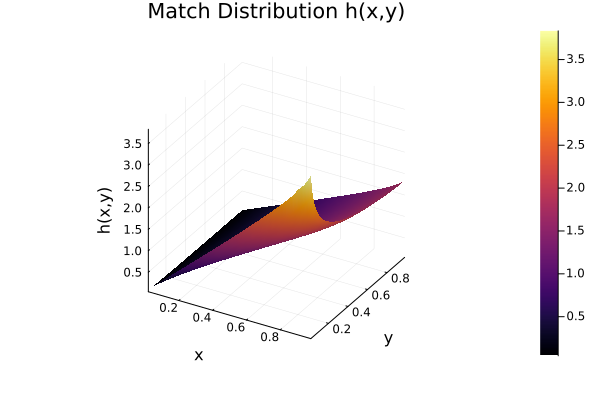

In [60]:
nx, ny, = grid.nx, grid.ny
x_grid, y_grid = grid.x_grid, grid.y_grid
surface(x_grid, y_grid, state.h;
    xlabel = "x", ylabel = "y", zlabel = "h(x,y)",
    title = "Match Distribution h(x,y)")

In [34]:
state.h

50×50 Matrix{Float64}:
 0.993257  0.992995  0.995666  1.02026   …  0.679914  0.59112   0.459826
 0.927544  0.927355  0.92981   0.952748     0.635344  0.552363  0.429644
 0.894235  0.894024  0.89638   0.91846      0.612709  0.532679  0.414317
 0.873608  0.873195  0.875569  0.897105     0.598613  0.520422  0.404772
 0.858635  0.859528  0.861329  0.882593     0.589075  0.512128  0.398314
 0.844589  0.850974  0.851974  0.872362  …  0.582388  0.506312  0.393783
 0.8275    0.839785  0.848161  0.868481     0.600705  0.526214  0.412104
 0.819787  0.834793  0.843124  0.871401     0.630781  0.569445  0.473412
 0.810667  0.826588  0.836577  0.862054     0.663571  0.614049  0.537465
 0.833606  0.855758  0.867147  0.890555     0.655122  0.618582  0.558403
 0.833611  0.849588  0.858435  0.878821  …  0.677401  0.639732  0.591499
 0.853199  0.872373  0.876612  0.890172     0.660237  0.630291  0.580405
 0.861089  0.882667  0.892046  0.897069     0.656708  0.627086  0.578801
 ⋮                          

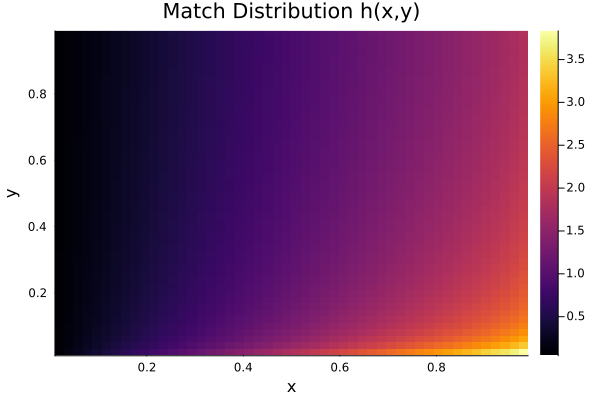

In [61]:
heatmap(grid.x_grid, grid.y_grid, state.h;
    xlabel = "x", ylabel = "y", title = "Match Distribution h(x,y)",
    color=:viridis, c=:auto)

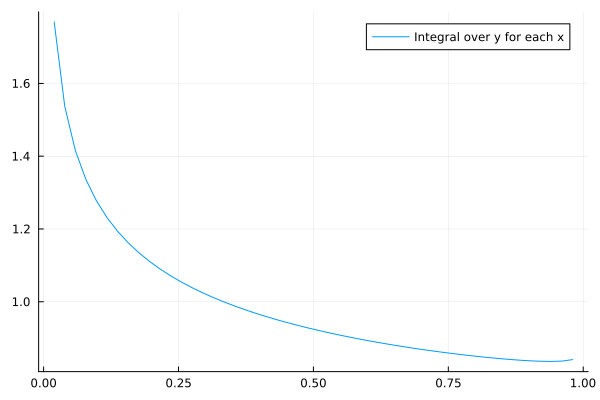

In [62]:
integral_h_x = [trapz(y_grid, view(state.h, i, :)) for i in 1:nx]
integral_h_y = [trapz(x_grid, view(state.h, :, j)) for j in 1:ny]

plot(grid.x_grid, integral_h_x, label="Integral over y for each x")

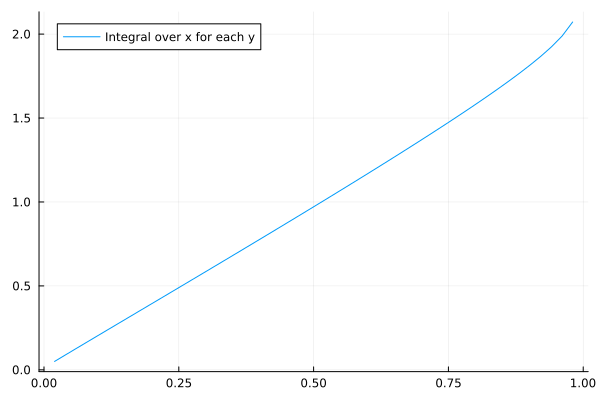

In [63]:
plot(y_grid, integral_h_y, label="Integral over x for each y")

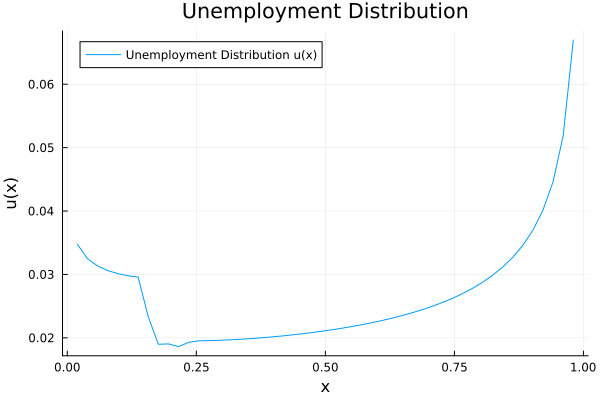

In [38]:
# unemployment distribution
plot(grid.x_grid, state.u, label="Unemployment Distribution u(x)",
    xlabel="x", ylabel="u(x)", title="Unemployment Distribution")

In [39]:
state.u .= update_ux(state.h, ℓx_vec, y_grid)
int_int_h = integrate_hxy(state.h, x_grid, y_grid)
println("Integral of h(x,y): ", int_int_h)
println("Total unemployment U: ", trapz(grid.x_grid, state.u))
println("Total mass: ", trapz(grid.x_grid, state.u) + int_int_h)
println("Total vacancies V: ", state.V)
println("Total number of jobs N: ", state.N)    

Integral of h(x,y): 0.9748996711242741
Total unemployment U: 0.025100328875726004
Total mass: 1.0000000000000002
Total vacancies V: 0.019677918476225683
Total number of jobs N: 0.9945080099249379


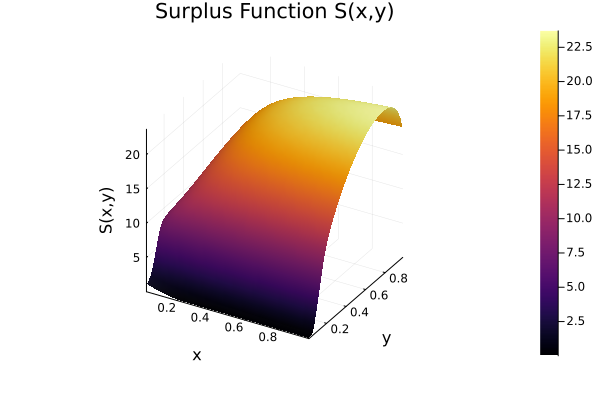

In [40]:
surface(x_grid, y_grid, state.S;
    xlabel = "x", ylabel = "y", zlabel = "S(x,y)",
    title = "Surplus Function S(x,y)")

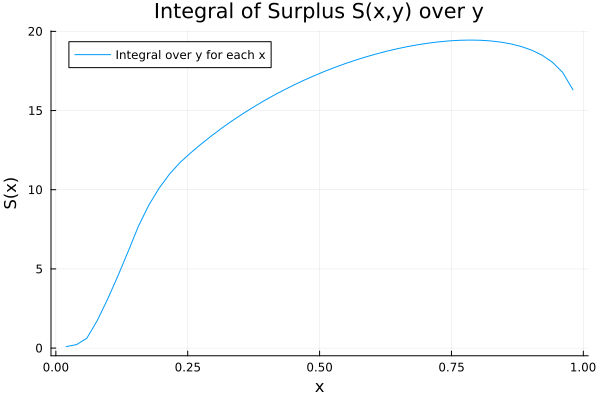

In [41]:
int_S_x = [trapz(y_grid, view(state.S, i, :)) for i in 1:nx]
int_S_y = [trapz(x_grid, view(state.S, :, j)) for j in 1:ny]

plot(grid.x_grid, int_S_x, label="Integral over y for each x",
    xlabel="x", ylabel="S(x)", title="Integral of Surplus S(x,y) over y")

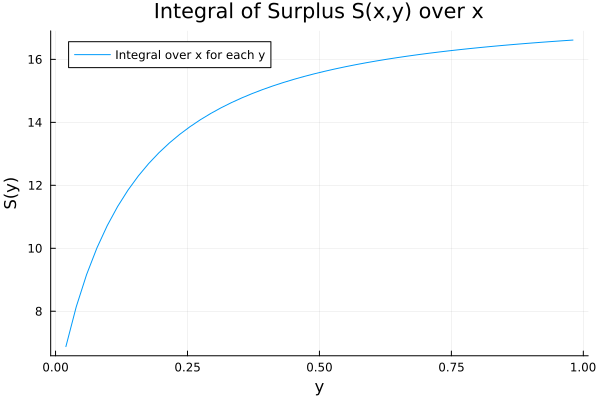

In [42]:
plot(y_grid, int_S_y, label="Integral over x for each y",
    xlabel="y", ylabel="S(y)", title="Integral of Surplus S(x,y) over x")

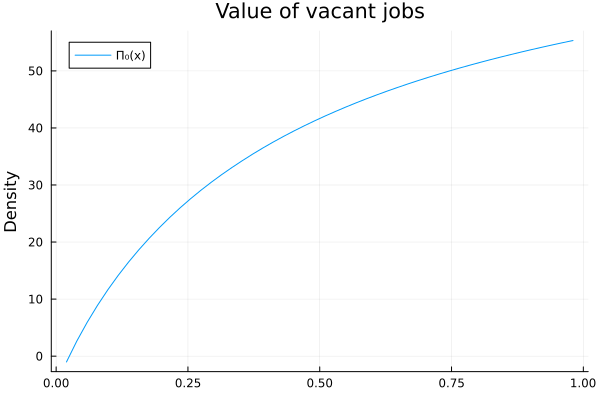

In [43]:
Π₀ = plot(y_grid, state.Pi0, label="Π₀(x)", ylabel="Density", title= "Value of vacant jobs")
display(Π₀)

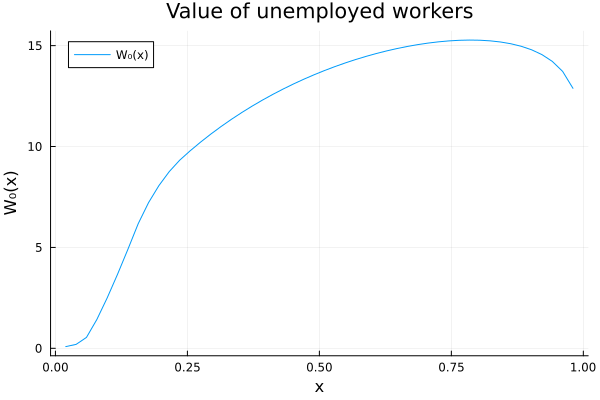

In [44]:
W0 = compute_W0(state.S, state.v, state, params, b_vec, grid.y_grid)
W0_plot = plot(grid.x_grid, W0, label="W₀(x)",
    xlabel="x", ylabel="W₀(x)", title="Value of unemployed workers")
display(W0_plot)

## Debugging

In [45]:
# -- Set your parameter values --
params = ModelParams(
    r = 0.05, δ = 0.017, ξ = 0.011, β = 0.188, c = 2.344, η = 0.65, s = 0.332,
    α = 0.607, ρ = 0.938, b = 0.122, ax = 0.797, bx = 0.987, ay = 1.988, by = 0.967, σ² = 0.006,
    A = 6.964 # Or your preferred A
)

# -- Set grid sizes --
nx, ny = 40, 40

# -- Initialise model and precomputes --
state, grid, ℓx_vec, ℓy_vec, fmat, b_vec = initialise_model(params, nx, ny)

x_grid, y_grid = grid.x_grid, grid.y_grid

# Optional: Print shapes and grid
println("nx = $nx, ny = $ny")
println("x_grid = ", x_grid)
println("y_grid = ", y_grid)

nx = 40, ny = 40
x_grid = [0.024390243902439025, 0.04878048780487805, 0.07317073170731707, 0.0975609756097561, 0.12195121951219512, 0.14634146341463414, 0.17073170731707318, 0.1951219512195122, 0.21951219512195122, 0.24390243902439024, 0.2682926829268293, 0.2926829268292683, 0.3170731707317073, 0.34146341463414637, 0.36585365853658536, 0.3902439024390244, 0.4146341463414634, 0.43902439024390244, 0.4634146341463415, 0.4878048780487805, 0.5121951219512195, 0.5365853658536586, 0.5609756097560976, 0.5853658536585366, 0.6097560975609756, 0.6341463414634146, 0.6585365853658537, 0.6829268292682927, 0.7073170731707317, 0.7317073170731707, 0.7560975609756098, 0.7804878048780488, 0.8048780487804879, 0.8292682926829268, 0.8536585365853658, 0.8780487804878049, 0.9024390243902439, 0.926829268292683, 0.9512195121951219, 0.975609756097561]
y_grid = [0.024390243902439025, 0.04878048780487805, 0.07317073170731707, 0.0975609756097561, 0.12195121951219512, 0.14634146341463414, 0.17073170731707318, 0.1951

In [46]:
# Print initial state arrays (sanity check)
println("Initial κ: ", state.κ)
println("Initial h min/max: ", minimum(state.h), " / ", maximum(state.h))
println("Initial S min/max: ", minimum(state.S), " / ", maximum(state.S))
println("Initial Pi0 min/max: ", minimum(state.Pi0), " / ", maximum(state.Pi0))

Initial κ: 0.1
Initial h min/max: 2.5481605876369284e-6 / 0.0002228449365857465
Initial S min/max: 1.0e-8 / 1.0e-8
Initial Pi0 min/max: 0.0 / 0.0


In [47]:
# Example usage
params = ModelParams(
    r = 0.05,
    δ = 0.017,
    ξ = 0.011,
    β = 0.188,
    c = 2.344,
    A = 6.96,
    η = 0.65,
    s = 0.332,
    α = 0.607,
    ρ = 0.938,
    b = 0.122,
    ax = 0.797,
    bx = 0.987,
    ay = 1.988,
    by = 0.967,
    σ² = 0.006
)

state, grid, ℓx_vec, ℓy_vec, fmat, b_vec = initialise_model(params, 40, 40)

(State([5.155841044157975e-6 1.0234815139665821e-5 … 0.00021242486018638397 0.0002228449365857465; 4.480571069427001e-6 8.894342595701457e-6 … 0.00018460318594512224 0.00019365852579294475; … ; 2.5481605876369284e-6 5.058331383237094e-6 … 0.00010498629649852398 0.00011013618916852919; 2.558044652502601e-6 5.077952154293109e-6 … 0.00010539352804022225 0.00011056339663852985], [1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; … ; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], 0.1, 1.0, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), GridParams(40, 40, [0.024390243902439025,

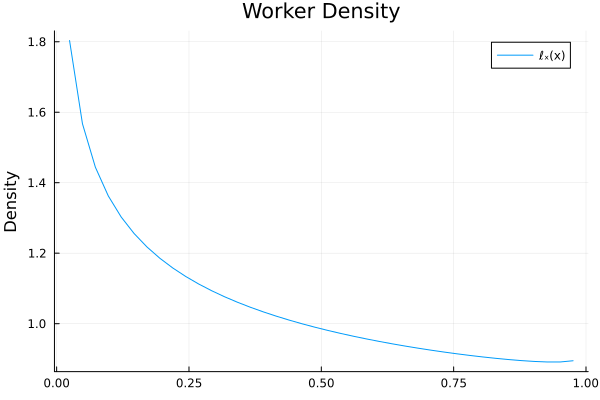

In [48]:
ℓx_vec_plot = plot(x_grid, ℓx_vec, label="ℓₓ(x)", ylabel="Density", title="Worker Density")
display(ℓx_vec_plot)

In [49]:
state.u .= update_ux(state.h, ℓx_vec, y_grid)
U = trapz(x_grid, state.u)

println("Updated u(x): ", state.u)
println("Total unemployment U: ", U)


Updated u(x): [1.803420156960094, 1.5672229054564542, 1.4438793255969289, 1.3624447468354441, 1.3025693535290888, 1.255700626667192, 1.2174736524534477, 1.1853749651992134, 1.1578319250673248, 1.1337988114144986, 1.1125471050542624, 1.093550220459867, 1.0764159997885518, 1.0608451109529422, 1.0466043134131338, 1.033508666601184, 1.0214093338553052, 1.0101850081487898, 0.9997357523784721, 0.9899784922410815, 0.9808436676685822, 0.9722727152422747, 0.9642161605591114, 0.9566321698758087, 0.9494854585338515, 0.9427464883894432, 0.9363909135976032, 0.9303992581816568, 0.9247568343516956, 0.9194539434328187, 0.91448645137607, 0.9098569172269136, 0.9055766164756095, 0.9016691372892205, 0.898176980210017, 0.895174457389655, 0.8927954525500638, 0.891302352849436, 0.8913005904483257, 0.894757857974378]
Total unemployment U: 0.99994394849338


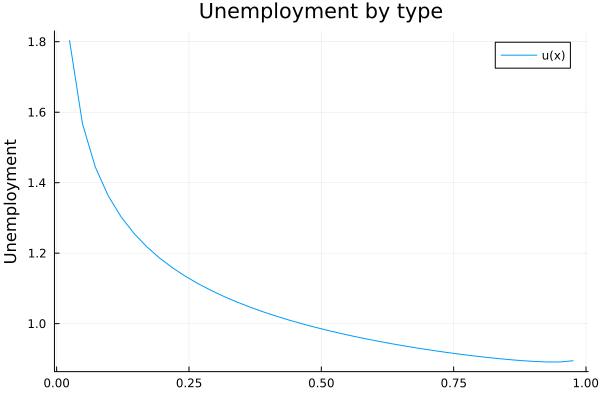

In [50]:
u_plot = plot(x_grid, state.u, label="u(x)", ylabel="Unemployment", title="Unemployment by type")
display(u_plot)

In [51]:
state.V = solve_V_from_kappa(state.κ, U, params)
state.N = state.V + 1 - U
state.v .= update_vy(state.h, state.N, ℓy_vec, x_grid)

println("Updated V: ", state.V)
println("Updated N: ", state.N)
println("Updated v(y): min = $(minimum(state.v)), max = $(maximum(state.v))")

Updated V: 42.25158200090526
Updated N: 42.25163805241188
Updated v(y): min = 2.1549338366470336, max = 93.14020546040979


In [52]:
h_new = update_hxy(state.h, state.u, state.v, state.S, state.κ, state.V, params, grid)
println("Updated h: min = $(minimum(h_new)), max = $(maximum(h_new))")
state.h .= h_new


Updated h: min = 0.04546124560406112, max = 3.975716711558298


40×40 Matrix{Float64}:
 0.0919844  0.182597   0.2728    …  3.51638  3.6447   3.78981  3.97572
 0.079937   0.158682   0.237071     3.05583  3.16734  3.29346  3.45501
 0.0736458  0.146193   0.218413     2.81533  2.91807  3.03425  3.18309
 0.0694922  0.137948   0.206094     2.65655  2.75349  2.86312  3.00357
 0.0664382  0.131886   0.197037     2.5398   2.63248  2.7373   2.87157
 0.0640477  0.12714    0.189947  …  2.44841  2.53776  2.6388   2.76825
 0.0620979  0.12327    0.184165     2.37388  2.4605   2.55847  2.68397
 0.0604607  0.12002    0.179309     2.31129  2.39563  2.49102  2.61321
 0.0590558  0.117231   0.175143     2.25758  2.33997  2.43314  2.55249
 0.05783    0.114798   0.171507     2.21072  2.2914   2.38263  2.49951
 0.056746   0.112646   0.168293  …  2.16929  2.24845  2.33797  2.45266
 0.0557771  0.110722   0.165419     2.13225  2.21006  2.29805  2.41078
 0.0549032  0.108988   0.162827     2.09884  2.17543  2.26204  2.37301
 ⋮                               ⋱                    

In [53]:
int_int_h = integrate_hxy(state.h, x_grid, y_grid)

1.0

In [54]:
S_new = update_Sxy(state.S, state.h, state.u, state.v, state.κ, params, grid, ℓy_vec, fmat, b_vec)
println("Updated S: min = $(minimum(S_new)), max = $(maximum(S_new))")
state.S .= S_new

Updated S: min = 29.406749959441687, max = 115.70611943884292


40×40 Matrix{Float64}:
 29.4067  30.2509  31.0824  31.9076  32.7289  …   59.4482   60.2549   61.0616
 31.0865  31.9526  32.8013  33.6408  34.4744      61.3443   62.1533   62.9622
 32.5785  33.4601  34.3219  35.1725  36.0159      63.0192   63.8303   64.6413
 33.9996  34.8935  35.7657  36.6256  37.4773      64.6014   65.4145   66.2275
 35.3839  36.2879  37.169   38.0367  38.8956      66.1307   66.9458   67.7606
 36.7458  37.6585  38.5472  39.4219  40.2871  …   67.6252   68.4421   69.2587
 38.0928  39.013   39.9084  40.7893  41.6602      69.0946   69.9132   70.7316
 39.4291  40.356   41.2574  42.1438  43.0199      70.5449   71.3652   72.1853
 40.7574  41.6903  42.5973  43.4887  44.3695      71.9801   72.8021   73.6237
 42.0796  43.018   43.9299  44.8261  45.7112      73.4029   74.2265   75.0497
 43.3968  44.3403  45.2568  46.1573  47.0465  …   74.8155   75.6406   76.4652
 44.7101  45.6582  46.5791  47.4835  48.3765      76.2192   77.0458   77.872
 46.0201  46.9725  47.8973  48.8056  49.70

In [55]:
for _ in 1:20
    update_Pi0!(state.Pi0, state.S, state.h, state.u, state.κ, params, grid, ℓx_vec, ℓy_vec)
end
println("Updated Pi0: min = $(minimum(state.Pi0)), max = $(maximum(state.Pi0))")

Updated Pi0: min = 35.6672694071315, max = 71.8085236676777


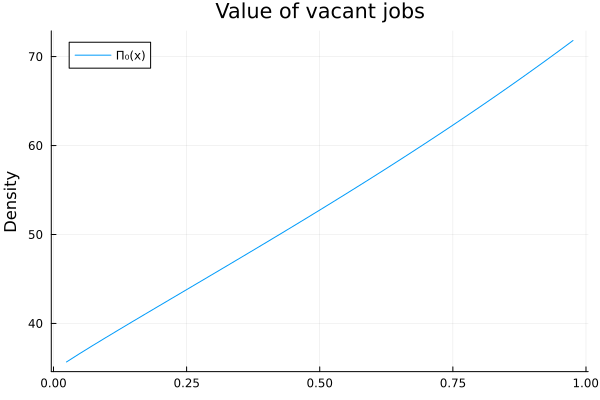

In [56]:
Π₀ = plot(y_grid, state.Pi0, label="Π₀(x)", ylabel="Density", title= "Value of vacant jobs")
display(Π₀)

In [57]:
κ_new = update_kappa(state.S, state.u, state.h, state.Pi0, params, grid, ℓy_vec, y_grid, x_grid)
println("Updated κ: ", κ_new)
state.κ = κ_new

Updated κ: 0.030938395462488083


0.030938395462488083